In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np
import importlib
import electricity_lib as ec_lib
import taipower_analyze_lib as analyze_lib

importlib.reload(ec_lib)
importlib.reload(analyze_lib)
pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams["font.family"] = "Microsoft JhengHei"

analyze_lib.build_output_folder()

In [46]:
# 讀取充放電時間參數
meter_contract_volume_dict = analyze_lib.contract_df_to_dict(
    pd.read_excel(analyze_lib.METER_CONTRACT_FILE_PATH))
raw_data = pd.read_excel(analyze_lib.METER_DATA_FILE_PATH, )
raw_data.drop(columns=analyze_lib.DEFAULT_DROP_COLS,
              inplace=True,
              errors="ignore")

METER_USAGE_COLS = analyze_lib.MeterUsageColumns()
ELEC_PRICE_COLS = analyze_lib.ElectricPriceColumns()
ELEC_PARAMS = analyze_lib.ElectricParameters(
    raw_elec_type_dict=ec_lib.get_elec_type_dict(
        analyze_lib.RAW_CONTRACT_TYPE),
    elec_type_dict=ec_lib.get_elec_type_dict(analyze_lib.CONTRACT_TYPE),
    release_hour_dict=ec_lib.get_release_hour_dict(analyze_lib.CONTRACT_TYPE,
                                                   analyze_lib.RELEASE_TYPE),
    charge_hour_dict=ec_lib.get_charege_hour_dict(analyze_lib.CONTRACT_TYPE,
                                                  analyze_lib.CHARGE_TYPE),
)
ELEC_PRICE_PARAMS = analyze_lib.ElecetricPriceParameters(
    charge_price_dict=ec_lib.get_charge_price_dict(analyze_lib.CONTRACT_TYPE),
    raw_contract_price_dict=ec_lib.get_contract_price_dict(
        analyze_lib.RAW_CONTRACT_TYPE),
    contract_price_dict=ec_lib.get_contract_price_dict(
        analyze_lib.CONTRACT_TYPE),
)
YEARLY_PROFIT_COLS = analyze_lib.YearlyProfitColumns()

# 將時間欄位轉換為日期時間格式
raw_data[METER_USAGE_COLS.time_col] = pd.to_datetime(
    raw_data[METER_USAGE_COLS.time_col])
raw_data[METER_USAGE_COLS.usage_col] = raw_data[analyze_lib.SUM_COLS].apply(
    lambda row: row.dropna().unique()[0]
    if row.nunique() == 1 else row.mode().iloc[0],
    axis=1,
)
raw_data[
    METER_USAGE_COLS.usage_col] = raw_data[METER_USAGE_COLS.usage_col] * 0.25
raw_data = raw_data.drop(columns=analyze_lib.SUM_COLS)
raw_data = raw_data.sort_values(by=[METER_USAGE_COLS.time_col], ascending=True)

# 增加欄位，確定充放電狀態 & 充放電量
remain_battery_kw_list = []
battery_kwh_list = []
raw_data[[
    METER_USAGE_COLS.battery_kw_col,
    METER_USAGE_COLS.battery_kwh_col,
    METER_USAGE_COLS.usage_with_battery_col,
    METER_USAGE_COLS.charge_kwh_col,
    METER_USAGE_COLS.release_kwh_col,
]] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.process_battery_usage(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS,
            remain_battery_kw_list,
            battery_kwh_list,
        ),
        axis=1,
    ).tolist(),
    index=raw_data.index,
)

# 計算電價、調整後電價
raw_data[[
    ELEC_PRICE_COLS.elec_charge_price_col,
    ELEC_PRICE_COLS.elec_charge_price_with_battery_col,
]] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.cal_elec_price(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS.elec_type_dict,
            ELEC_PRICE_PARAMS.charge_price_dict,
        ),
        axis=1,
    ).tolist(), )

hourly_data_with_dr_price = analyze_lib.cal_hourly_dr_price(
    raw_data, METER_USAGE_COLS, ELEC_PRICE_COLS)
monthly_dr_price = analyze_lib.group_all_data_in_freq(
    hourly_data_with_dr_price, "ME", METER_USAGE_COLS, ELEC_PRICE_COLS)

# calculate new contract volume
# calculate new basic contract price
contract_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    meter_contract_volume_dict, ELEC_PRICE_PARAMS.raw_contract_price_dict)
new_contract_volume_dict = analyze_lib.cal_new_contract_volume(
    raw_data, METER_USAGE_COLS, ELEC_PARAMS.elec_type_dict,
    analyze_lib.CONTRACT_TYPE)
new_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    new_contract_volume_dict, ELEC_PRICE_PARAMS.contract_price_dict)

monthly_data = analyze_lib.group_all_data_withour_dr_in_freq(
    raw_data,
    "ME",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)

monthly_data[METER_USAGE_COLS.dr_volume_col] = monthly_dr_price[
    METER_USAGE_COLS.dr_volume_col]
monthly_data[ELEC_PRICE_COLS.demand_price_col] = monthly_dr_price[
    ELEC_PRICE_COLS.demand_price_col]

yearly_profit = analyze_lib.cal_year_profit(
    monthly_data,
    contract_monthly_basic_price,
    new_monthly_basic_price,
    ELEC_PRICE_COLS,
    YEARLY_PROFIT_COLS,
)
# output yearly profit to excel
yearly_profit.to_excel(
    f"{analyze_lib.OUTPUT_FOLDER}年度效益_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.xlsx",
    index=False,
    sheet_name="年度效益",
)

In [40]:
# 15分最大需量分析圖
expensive_15_usage = analyze_lib.filter_expensive_usage(
    raw_data, METER_USAGE_COLS, ELEC_PARAMS)
max_hour_demand_expensive_summary = analyze_lib.group_all_data_withour_dr_in_freq(
    expensive_15_usage,
    "h",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)
max_hour_demand_expensive_summary.to_excel(
    f"{analyze_lib.OUTPUT_FOLDER}尖峰時段_小時需量_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.xlsx",
    index=False,
    sheet_name="尖峰時段_15分鐘最高需量",
)
max_demand_expensive_summary = analyze_lib.group_max_data_without_dr_in_freq(
    max_hour_demand_expensive_summary,
    "D",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)

original_max_demand_power = max_demand_expensive_summary[
    METER_USAGE_COLS.usage_col].max()
new_max_demand_power = max_demand_expensive_summary[
    METER_USAGE_COLS.usage_with_battery_col].max()

# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
date_list = max_demand_expensive_summary[METER_USAGE_COLS.time_col]
fig, ax = plt.subplots(figsize=(16, 7))
summer_start_index, summer_end_index = 0, 0
for i in range(len(date_list)):
    date = date_list[i]
    if date.month == 5 and date.day == 16:
        summer_start_index = i

    elif date.month == 10 and date.day == 15:
        summer_end_index = i

ax.fill_between(
    range(len(date_list)),
    max_demand_expensive_summary[METER_USAGE_COLS.usage_col].values,
    label="Daily Summary",
    color="royalblue",
    linewidth=1.2,
    alpha=0.8,
)
ax.fill_between(
    range(summer_start_index, summer_end_index),
    max_demand_expensive_summary[METER_USAGE_COLS.usage_col].
    values[summer_start_index:summer_end_index],
    label="Daily Summary",
    color="orange",
    linewidth=1.2,
    alpha=0.8,
)
# 繪製第二個 DataFrame 的折線圖
ax.fill_between(
    range(len(date_list)),
    max_demand_expensive_summary[
        METER_USAGE_COLS.usage_with_battery_col].values,
    label="Lower Daily Summary",
    color="lightblue",
    linewidth=1.2,
    alpha=0.8,
)
# 設置契約容量線
if ELEC_PARAMS.contract_type == ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE:
    contract_value = meter_contract_volume_dict.get(ec_lib.UsageType.PEAK)
    ax.hlines(
        y=contract_value,
        xmin=summer_start_index,
        xmax=summer_end_index,
        color="green",
        linestyle="-",
    )
    contract_value += meter_contract_volume_dict.get(
        ec_lib.UsageType.SEMI_PEAK)
    ax.hlines(
        y=[contract_value, contract_value],
        color="green",
        linestyle="-",
        xmin=[0, summer_end_index],
        xmax=[summer_start_index, len(date_list)],
    )
elif ELEC_PARAMS.contract_type == ec_lib.ContractType.HIGH_PRESSURE_BATCH:

    ax.axhline(
        y=meter_contract_volume_dict.get(ec_lib.UsageType.PEAK),
        color="green",
        linestyle="--",
    )

# 設置平均線
ax.axhline(y=original_max_demand_power, color="red", linestyle="--")
ax.axhline(y=new_max_demand_power, color="brown", linestyle="--")

# 設置 X 軸的顯示間隔
x_labels = date_list.dt.strftime("%Y-%m-%d")
tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔
ax.set_xticks(tick_positions)
ax.set_xticklabels([x_labels[i] for i in tick_positions],
                   rotation=90,
                   fontsize=12)
ax.set_xlim(left=0, right=len(x_labels))  # X 軸從 0 開始
ax.set_ylim(bottom=0)

# 圖表設置
plt.title("尖峰時段 15分鐘最高需量", fontsize=16)
plt.xlabel("日期", fontsize=14)
plt.ylabel("最高需量 (kW)", fontsize=14)

legend_elements = [
    Patch(facecolor="orange", label="(原)夏月尖峰需量"),
    Patch(facecolor="royalblue", label="(原)非夏月尖峰需量"),
    Patch(facecolor="lightblue", label="新尖峰需量"),
    Patch(
        color="green",
        label="(原)合約需量",
    ),
    Patch(color="red", label=f"(原)尖峰最高需量: {original_max_demand_power:.2f}"),
    Patch(color="brown", label=f"新尖峰最高需量: {new_max_demand_power:.2f}"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.savefig(
    f"{analyze_lib.OUTPUT_FOLDER}尖峰時段_15分鐘最高需量_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close("all")

In [41]:
plt.figure(figsize=(25, 10))

# 設定 X 軸位置
x = np.arange(len(contract_monthly_basic_price))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

contract_bar = plt.bar(
    x - width / 2,
    contract_monthly_basic_price.values(),
    color="skyblue",
    width=bar_width,
    label="原契約月基本費",
)
plt.bar_label(
    contract_bar,
    labels=[f"{round(v):,}" for v in contract_monthly_basic_price.values()],
    fontsize=10,
)
new_contract_bar = plt.bar(
    x + width / 2,
    new_monthly_basic_price.values(),
    color="orange",
    width=bar_width,
    label="新契約月基本費",
)
plt.bar_label(
    new_contract_bar,
    labels=[f"{round(v):,}" for v in new_monthly_basic_price.values()],
    fontsize=10,
)

plt.xticks(x, contract_monthly_basic_price.keys(), fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("基本費用比較表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("基本費用", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="原契約月基本費"),
    Patch(facecolor="orange", label="新契約月基本費"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.savefig(
    f"{analyze_lib.OUTPUT_FOLDER}基本費用比較_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close("all")

In [42]:
plt.figure(figsize=(25, 10))

# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

elec_charge_bar = plt.bar(
    x - width / 2,
    monthly_data[ELEC_PRICE_COLS.elec_charge_price_col],
    color="skyblue",
    width=bar_width,
    label="原月度流動電費",
)
plt.bar_label(
    elec_charge_bar,
    label_type="edge",
    labels=[
        f"{round(v):,}"
        for v in monthly_data[ELEC_PRICE_COLS.elec_charge_price_col]
    ],
    fontsize=12,
)
elec_charge_with_battery_bar = plt.bar(
    x + width / 2,
    monthly_data[ELEC_PRICE_COLS.elec_charge_price_with_battery_col],
    color="orange",
    width=bar_width,
    label="新月度流動電費",
)
plt.bar_label(
    elec_charge_with_battery_bar,
    label_type="edge",
    labels=[
        f"{round(v):,}" for v in monthly_data[
            ELEC_PRICE_COLS.elec_charge_price_with_battery_col]
    ],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1])
plt.xticks(x, display_month_list, fontsize=12)
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.title("流動電費比較表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("電費", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="原月度流動電費"),
    Patch(facecolor="orange", label="新月度流動電費"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.savefig(
    f"{analyze_lib.OUTPUT_FOLDER}流動電費比較_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close("all")

In [43]:
fig, ax1 = plt.subplots(figsize=(16, 7))
# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5

# for first y axis
dr_price_bar = ax1.bar(
    x,
    monthly_data[ELEC_PRICE_COLS.demand_price_col],
    color="skyblue",
    label="需量價金",
)
ax1.bar_label(
    dr_price_bar,
    labels=[
        f"{round(v):,}" for v in monthly_data[ELEC_PRICE_COLS.demand_price_col]
    ],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1])

ax1.set_xticks(x)
ax1.set_xticklabels(display_month_list, fontsize=12)

# 設定 Y 軸格式（千分位）
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
# 設定標題與軸標籤
ax1.set_title("需量價金效益", fontsize=14)
ax1.set_xlabel("月份", fontsize=12)
ax1.set_ylabel("價金", fontsize=12)

ax2 = ax1.twinx()
ax2_y = monthly_data[METER_USAGE_COLS.dr_volume_col]
ax2.plot(x, ax2_y, color="orange", label="需量")
for i, txt in enumerate(ax2_y):
    ax2.annotate(f"{float(txt):,.2f}", (x[i], ax2_y[i]),
                textcoords="offset points",
                xytext=(0, -15),
                size=12,
                ha='center')
ax2.set_ylabel("需量(MW)", fontsize=12)

plt.savefig(
    f"{analyze_lib.OUTPUT_FOLDER}需量價金效益_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close("all")

In [44]:
plt.figure(figsize=(16, 7))

# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

charge_price_bars = plt.bar(
    x - width / 2,
    -(monthly_data[METER_USAGE_COLS.charge_kwh_col]),
    color="skyblue",
    width=bar_width,
    label="充電電費",
)
plt.bar_label(
    charge_price_bars,
    labels=[f"{round(v):,}" for v in -(monthly_data[METER_USAGE_COLS.charge_kwh_col])],
    fontsize=12,
)
release_price_bars = plt.bar(
    x + width / 2,
    monthly_data[METER_USAGE_COLS.release_kwh_col],
    color="orange",
    width=bar_width,
    label="放電電費",
)
plt.bar_label(
    release_price_bars,
    labels=[f"{round(v):,}" for v in monthly_data[METER_USAGE_COLS.release_kwh_col]],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1]
)
plt.xticks(x, display_month_list, fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("每月電池充放電量表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("充放電量", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="充電量"),
    Patch(facecolor="orange", label="放電量"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.savefig(
    f"{analyze_lib.OUTPUT_FOLDER}電池充放電量表_{analyze_lib.CONTRACT_TYPE.value}_{analyze_lib.METER_NO}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.close("all")

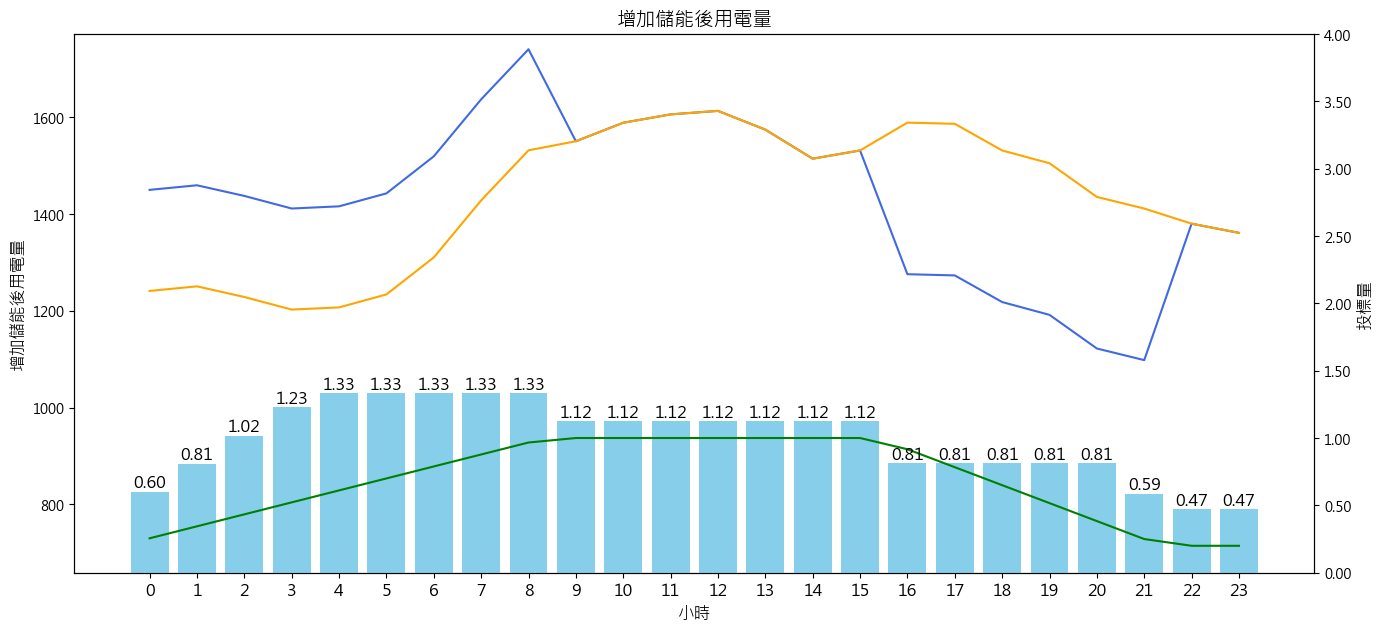

In [82]:
daily_data_with_dr = analyze_lib.group_all_data_in_freq(
    hourly_data_with_dr_price, 'd', METER_USAGE_COLS, ELEC_PRICE_COLS)
(summer_profit_day, non_summer_profit_day) = analyze_lib.find_most_profit_day(
    daily_data_with_dr, METER_USAGE_COLS, ELEC_PRICE_COLS)

summer_profit_data = hourly_data_with_dr_price[
    (hourly_data_with_dr_price[METER_USAGE_COLS.time_col].dt.year ==
     summer_profit_day.year) & (hourly_data_with_dr_price[
         METER_USAGE_COLS.time_col].dt.month == summer_profit_day.month) &
    (hourly_data_with_dr_price[METER_USAGE_COLS.time_col].dt.day
     == summer_profit_day.day)]

non_summer_profit_data = hourly_data_with_dr_price[
    (hourly_data_with_dr_price[METER_USAGE_COLS.time_col].dt.year ==
     non_summer_profit_day.year) & (hourly_data_with_dr_price[
         METER_USAGE_COLS.time_col].dt.month == non_summer_profit_day.month) &
    (hourly_data_with_dr_price[METER_USAGE_COLS.time_col].dt.day
     == non_summer_profit_day.day)]

fig, ax1 = plt.subplots(figsize=(16, 7))
x = np.arange(len(summer_profit_data[METER_USAGE_COLS.time_col]))
# 設定柱狀圖的寬度
width = 0.5

ax1.plot(x,
         summer_profit_data[METER_USAGE_COLS.usage_with_battery_col],
         color="royalblue",
         label="增加儲能後用電量")
ax1.plot(x,
         summer_profit_data[METER_USAGE_COLS.usage_col],
         color="orange",
         label="原用電量")
ax1.set_xticks(x)
ax1.set_xticklabels(summer_profit_data[METER_USAGE_COLS.time_col].dt.hour,
                    fontsize=12)
ax1.set_ylim(
    bottom=summer_profit_data[METER_USAGE_COLS.usage_with_battery_col].min() *
    0.6)
ax1.set_title("增加儲能後用電量", fontsize=14)
ax1.set_xlabel("小時", fontsize=12)
ax1.set_ylabel("增加儲能後用電量", fontsize=12)

ax2 = ax1.twinx()
# for first y axis
dr_volume_bar = ax2.bar(
    x,
    summer_profit_data[METER_USAGE_COLS.dr_volume_col],
    color="skyblue",
    label="需量投標量",
)
ax2.bar_label(
    dr_volume_bar,
    labels=[
        f"{v:,.2f}" for v in summer_profit_data[METER_USAGE_COLS.dr_volume_col]
    ],
    fontsize=12,
)
ax2.plot(x,
         summer_profit_data[METER_USAGE_COLS.battery_kwh_col] /
         analyze_lib.BATTERY_KWH,
         color="green",
         label="SOC")
ax2.set_ylim(0,
             top=summer_profit_data[METER_USAGE_COLS.dr_volume_col].max() * 3)
ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{float(x):,.2f}"))
# 設定標題與軸標籤
ax2.set_ylabel("投標量", fontsize=12)

plt.show()
